In [23]:
import pandas as pd
from tuner import computeMetric
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import config
def computeMetric(metric, cancer, p, all_pred_outputs, std=True, clamp_prediction_bounds=[]):
    current_outputs = all_pred_outputs[(all_pred_outputs.cancer == cancer) & (all_pred_outputs.p == p)]
    
    metric_means = []
    for iteration in current_outputs.iteration.unique():
        current_iteration_preds = current_outputs[current_outputs.iteration==iteration]

        if metric in ["precision", "recall", "f1-score"]:
            cur_report = classification_report(current_iteration_preds.actual, current_iteration_preds.predicted, output_dict=True, zero_division=0)
            cur_metric = cur_report["macro avg"][metric]
        elif metric == "rmse":
            raw_predictions = current_iteration_preds["predicted-raw"]
            if clamp_prediction_bounds:
                raw_predictions = np.clip(raw_predictions, clamp_prediction_bounds[0], clamp_prediction_bounds[1])
            cur_metric = mean_squared_error(current_iteration_preds.actual, raw_predictions, squared=False)
        metric_means.append(cur_metric)

    metrics = np.array(metric_means)
    return metrics


In [24]:
cancer = "ESCA"
target = "stage"
model = "enet"
# modalities = ["aak_ge_ae", "tcma_gen"]
modalities = ["aak_ge", "tcma_gen_aak_ge"]
selection = "elasticnet"
prediction_tables_root = f"Data/Descriptor/Prediction_Tables/random_sampling/{target}/{model}"
# prediction_tables_root = f"Data/Descriptor/Prediction_Tables/super/random_sampling/{target}/{model}"
l, r = [pd.read_csv(f"{prediction_tables_root}/{selection}/{x}_{selection}_predoutput.csv", index_col=None) for x in modalities]
d = [l, r]
pairs = [None, None]
for i, x in enumerate(d):
    metrics = computeMetric("rmse", cancer=cancer, p=0, all_pred_outputs=x, clamp_prediction_bounds=config.prediction_bounds[target])
    pairs[i] = metrics
# np.mean(pairs[1])
r

,predicted,predicted-raw,actual,iteration,cancer,p,sampling,model,selection
0,2,1.617011,2,0,COAD,200,random_sampling,enet,elasticnet
1,1,1.113528,1,0,COAD,200,random_sampling,enet,elasticnet
2,3,2.530945,4,0,COAD,200,random_sampling,enet,elasticnet
3,1,1.032448,0,0,COAD,200,random_sampling,enet,elasticnet
4,2,1.974450,3,0,COAD,200,random_sampling,enet,elasticnet
...,...,...,...,...,...,...,...,...,...
100795,3,3.118561,3,199,STAD,0,random_sampling,enet,elasticnet
100796,2,1.619195,3,199,STAD,0,random_sampling,enet,elasticnet
100797,1,1.064695,0,199,STAD,0,random_sampling,enet,elasticnet
100798,2,1.742338,2,199,STAD,0,random_sampling,enet,elasticnet


(array([ 7., 25., 44., 56., 33., 19., 12.,  2.,  1.,  1.]),
 array([0.4734156 , 0.54380536, 0.61419512, 0.68458487, 0.75497463,
        0.82536438, 0.89575414, 0.96614389, 1.03653365, 1.1069234 ,
        1.17731316]),
 <BarContainer object of 10 artists>)

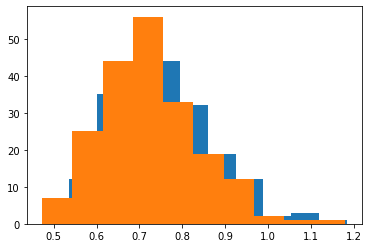

In [28]:
import matplotlib.pyplot as plt
plt.hist(pairs[0])
plt.hist(pairs[1])

In [25]:
from scipy import stats
# https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/
stats.wilcoxon(pairs[0], pairs[1])

WilcoxonResult(statistic=7813.0, pvalue=0.006342646714416907)

In [ ]:
# Compute all baselines